# Evidence Detection

## Data is in the form of: Claim, Evidence, Labels

## Labels
- **1 (Relevant)** - The evidence supports or is related to the claim.
- **0 (Not Relevant)** – The evidence does not support or is unrelated to the claim.

### Dependency Management

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 19.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nltk
import pickle
import os
import optuna

[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Create a directory for NLTK data
nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)

# Set the NLTK data path
nltk.data.path.append(nltk_data_dir)

# Download punkt to the specified directory
nltk.download('punkt_tab', download_dir=nltk_data_dir)

In [ ]:
from evidence_detection.bilstm_with_attention import BiLSTMAttention
from evidence_detection.evidence_detection_dataset import EvidenceDetectionDataset
from evidence_detection.vocabulary import Vocabulary
from evidence_detection.trainer import Trainer

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Define Glove Embedding Method

In [ ]:
def load_glove_embeddings(vocab, glove_path, embedding_dim=300):
    """Load GloVe embeddings for words in vocabulary"""
    embeddings = np.zeros((len(vocab), embedding_dim))

    # Initialize random embeddings
    for i in range(len(vocab)):
        embeddings[i] = np.random.normal(scale=0.1, size=(embedding_dim, ))

    # Load pretrained embeddings
    if not os.path.exists(glove_path):
        print(f"GloVe embeddings not found at {glove_path}. Using random embeddings.")
        return embeddings

    print(f"Loading GloVe embeddings from {glove_path}...")

    with open(glove_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Loading GloVe")):
            try:
                values = line.split()

                # Check if the vector has the correct dimension
                if len(values) != embedding_dim + 1:  # +1 for the word itself
                    print(f"Warning: Line {i} has {len(values)} values, expected {embedding_dim + 1}. Skipping.")
                    continue

                word = values[0]
                if word in vocab.stoi:
                    vector = np.array(values[1:], dtype='float32')

                    # Double-check vector dimension
                    if len(vector) != embedding_dim:
                        print(f"Warning: Vector for word '{word}' has dimension {len(vector)}, expected {embedding_dim}. Skipping.")
                        continue

                    embeddings[vocab.stoi[word]] = vector
            except Exception as e:
                print(f"Error processing line {i}: {e}")
                continue

    print(f"Loaded {embedding_dim}-dimensional GloVe embeddings.")
    return embeddings

### Get Data, build vocabulary and Build Glove Embeddings

In [ ]:
# Load datasets
print("Loading datasets...")
print("Using train.csv for train and validation")
train_df = pd.read_csv('./data/train.csv')
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"Train shape: {train_df.shape}, Validation shape: {val_df.shape}")
print(f"Label distribution in train: {train_df['label'].value_counts().to_dict()}")
print(f"Label distribution in val: {val_df['label'].value_counts().to_dict()}")

Loading datasets...
Using train.csv for train and validation
Train shape: (17206, 3), Validation shape: (4302, 3)
Label distribution in train: {0: 12504, 1: 4702}
Label distribution in val: {0: 3150, 1: 1152}


In [ ]:
# Load or create vocabulary
vocab_path = 'vocab.pkl'
if os.path.exists(vocab_path):
    print(f"Loading vocabulary from {vocab_path}")
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
else:
    print("Creating new vocabulary")
    vocab = Vocabulary(freq_threshold=3)
    all_texts = train_df['Claim'].tolist() + train_df['Evidence'].tolist()
    vocab.build_vocabulary(all_texts)

    # Save vocabulary
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)

print(f"Vocabulary size: {len(vocab)}")

Creating new vocabulary


Building vocabulary: 100%|██████████| 34412/34412 [00:04<00:00, 8596.82it/s]

Vocabulary size: 12686
Vocabulary size: 12686


In [ ]:
# Load GloVe embeddings
embedding_dim = 300
glove_path = "glove.6B.300d.txt"
embeddings = load_glove_embeddings(vocab, glove_path, embedding_dim)

Loading GloVe embeddings from glove.6B.300d.txt...


Loading GloVe: 160508it [00:03, 49736.92it/s]

Loaded 300-dimensional GloVe embeddings.


### Hyperparameter Tuning

In [ ]:
# Create datasets
train_dataset = EvidenceDetectionDataset(train_df, vocab)
val_dataset = EvidenceDetectionDataset(val_df, vocab)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

num_layers = 1
# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    hidden_dim = trial.suggest_categorical('hidden_dim', [128, 256, 512])
    dropout = trial.suggest_float('dropout', 0.3, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    # Initialize model with suggested parameters
    model = BiLSTMAttention(
        vocab_size=len(vocab),
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout,
        pretrained_embeddings=embeddings
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        device=device
    )

    # Train for a few epochs
    trainer.train(num_epochs=5)  # Reduced epochs for faster hyperparameter search

    # Evaluate on validation set
    val_metrics = trainer.evaluate()

    # Return F1 score as the optimization metric
    return val_metrics['f1']

# Create study directory
os.makedirs('model_architecture_parameters', exist_ok=True)

# Create and run Optuna study
study = optuna.create_study(direction='maximize',
                           study_name='bilstm_attention_optimization'
                          #  storage='sqlite:///model_architecture_parameters/bilstm_attention.db'
                            )
study.optimize(objective, n_trials=20)  # Adjust number of trials as needed

# Print and save best parameters
print("Best trial:")
trial = study.best_trial
print(f"  Value (F1 Score): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Save best parameters
with open('model_architecture_parameters/parameters.pkl', 'wb') as f:
    pickle.dump(trial.params, f)

[I 2025-03-28 00:50:47,138] A new study created in memory with name: bilstm_attention_optimization


Train dataset size: 17206
Validation dataset size: 4302
Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 107.61it/s]


Epoch 1/5 - Time: 26.20s
Train Loss: 0.4791, Train F1: 0.4478
Val Loss: 0.4037, Val F1: 0.6330
Val Precision: 0.7019, Val Recall: 0.5764
Validation F1 increased (0.000000 --> 0.632984). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.35it/s]


Epoch 2/5 - Time: 24.77s
Train Loss: 0.3852, Train F1: 0.6400
Val Loss: 0.3759, Val F1: 0.6326
Val Precision: 0.7299, Val Recall: 0.5582
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 104.09it/s]


Epoch 3/5 - Time: 24.77s
Train Loss: 0.3435, Train F1: 0.6973
Val Loss: 0.3676, Val F1: 0.6752
Val Precision: 0.6896, Val Recall: 0.6615
Validation F1 increased (0.632984 --> 0.675233). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.31it/s]


Epoch 4/5 - Time: 24.86s
Train Loss: 0.3046, Train F1: 0.7458
Val Loss: 0.3777, Val F1: 0.6605
Val Precision: 0.7058, Val Recall: 0.6207
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 106.50it/s]


Epoch 5/5 - Time: 24.84s
Train Loss: 0.2611, Train F1: 0.7945
Val Loss: 0.4261, Val F1: 0.6857
Val Precision: 0.6250, Val Recall: 0.7595
Validation F1 increased (0.675233 --> 0.685737). Saving model...
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 107.57it/s]
[I 2025-03-28 00:53:00,579] Trial 0 finished with value: 0.6857366771159875 and parameters: {'hidden_dim': 256, 'dropout': 0.4162741484571332, 'batch_size': 16, 'learning_rate': 0.00014139352015133768, 'weight_decay': 1.0938111637710662e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 107.55it/s]


Epoch 1/5 - Time: 25.39s
Train Loss: 0.4333, Train F1: 0.5689
Val Loss: 0.3992, Val F1: 0.5421
Val Precision: 0.7754, Val Recall: 0.4167
Validation F1 increased (0.000000 --> 0.542067). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.07it/s]


Epoch 2/5 - Time: 25.43s
Train Loss: 0.3137, Train F1: 0.7379
Val Loss: 0.3861, Val F1: 0.6195
Val Precision: 0.7569, Val Recall: 0.5243
Validation F1 increased (0.542067 --> 0.619487). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.71it/s]


Epoch 3/5 - Time: 24.92s
Train Loss: 0.2047, Train F1: 0.8443
Val Loss: 0.5273, Val F1: 0.6339
Val Precision: 0.6722, Val Recall: 0.5998
Validation F1 increased (0.619487 --> 0.633945). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.10it/s]


Epoch 4/5 - Time: 24.58s
Train Loss: 0.1129, Train F1: 0.9257
Val Loss: 0.7119, Val F1: 0.6188
Val Precision: 0.6322, Val Recall: 0.6059
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.71it/s]


Epoch 5/5 - Time: 24.48s
Train Loss: 0.0548, Train F1: 0.9646
Val Loss: 0.9054, Val F1: 0.6107
Val Precision: 0.5886, Val Recall: 0.6345
EarlyStopping counter: 2 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.48it/s]
[I 2025-03-28 00:55:08,089] Trial 1 finished with value: 0.6339449541284403 and parameters: {'hidden_dim': 512, 'dropout': 0.3479339528484242, 'batch_size': 16, 'learning_rate': 0.0015404150849096451, 'weight_decay': 2.7101392175538875e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.82it/s]


Epoch 1/5 - Time: 23.90s
Train Loss: 0.4382, Train F1: 0.5597
Val Loss: 0.3888, Val F1: 0.5969
Val Precision: 0.7520, Val Recall: 0.4948
Validation F1 increased (0.000000 --> 0.596859). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.35it/s]


Epoch 2/5 - Time: 23.95s
Train Loss: 0.3150, Train F1: 0.7275
Val Loss: 0.3813, Val F1: 0.6742
Val Precision: 0.6309, Val Recall: 0.7240
Validation F1 increased (0.596859 --> 0.674212). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.21it/s]


Epoch 3/5 - Time: 24.04s
Train Loss: 0.2012, Train F1: 0.8490
Val Loss: 0.4607, Val F1: 0.6417
Val Precision: 0.6092, Val Recall: 0.6780
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.70it/s]


Epoch 4/5 - Time: 24.12s
Train Loss: 0.1035, Train F1: 0.9291
Val Loss: 0.8651, Val F1: 0.6090
Val Precision: 0.6194, Val Recall: 0.5990
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.71it/s]


Epoch 5/5 - Time: 24.07s
Train Loss: 0.0530, Train F1: 0.9663
Val Loss: 0.9623, Val F1: 0.5971
Val Precision: 0.6374, Val Recall: 0.5616
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.33it/s]
[I 2025-03-28 00:57:10,800] Trial 2 finished with value: 0.6742118027485853 and parameters: {'hidden_dim': 256, 'dropout': 0.45054155231385834, 'batch_size': 16, 'learning_rate': 0.0013429969946494808, 'weight_decay': 3.076464973106319e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.11it/s]


Epoch 1/5 - Time: 23.94s
Train Loss: 0.4869, Train F1: 0.4399
Val Loss: 0.4012, Val F1: 0.6104
Val Precision: 0.6963, Val Recall: 0.5434
Validation F1 increased (0.000000 --> 0.610434). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.62it/s]


Epoch 2/5 - Time: 24.11s
Train Loss: 0.3931, Train F1: 0.6275
Val Loss: 0.3812, Val F1: 0.6575
Val Precision: 0.6957, Val Recall: 0.6233
Validation F1 increased (0.610434 --> 0.657509). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.21it/s]


Epoch 3/5 - Time: 24.04s
Train Loss: 0.3531, Train F1: 0.6792
Val Loss: 0.3703, Val F1: 0.6499
Val Precision: 0.7189, Val Recall: 0.5929
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.49it/s]


Epoch 4/5 - Time: 23.99s
Train Loss: 0.3195, Train F1: 0.7264
Val Loss: 0.3780, Val F1: 0.6654
Val Precision: 0.7027, Val Recall: 0.6319
Validation F1 increased (0.657509 --> 0.665448). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.59it/s]


Epoch 5/5 - Time: 23.99s
Train Loss: 0.2818, Train F1: 0.7704
Val Loss: 0.3947, Val F1: 0.6681
Val Precision: 0.6521, Val Recall: 0.6849
Validation F1 increased (0.665448 --> 0.668078). Saving model...
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.64it/s]
[I 2025-03-28 00:59:13,578] Trial 3 finished with value: 0.668077900084674 and parameters: {'hidden_dim': 256, 'dropout': 0.450789195290133, 'batch_size': 16, 'learning_rate': 0.00012202871935316008, 'weight_decay': 4.896957084847954e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 135/135 [00:01<00:00, 72.00it/s]


Epoch 1/5 - Time: 16.74s
Train Loss: 0.4457, Train F1: 0.5311
Val Loss: 0.3815, Val F1: 0.6746
Val Precision: 0.6845, Val Recall: 0.6649
Validation F1 increased (0.000000 --> 0.674593). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 70.95it/s]


Epoch 2/5 - Time: 16.73s
Train Loss: 0.3427, Train F1: 0.7004
Val Loss: 0.3728, Val F1: 0.6420
Val Precision: 0.7446, Val Recall: 0.5642
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.47it/s]


Epoch 3/5 - Time: 16.66s
Train Loss: 0.2531, Train F1: 0.8030
Val Loss: 0.4162, Val F1: 0.6554
Val Precision: 0.6931, Val Recall: 0.6215
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 135/135 [00:01<00:00, 70.64it/s]


Epoch 4/5 - Time: 16.67s
Train Loss: 0.1553, Train F1: 0.8862
Val Loss: 0.4888, Val F1: 0.6651
Val Precision: 0.6221, Val Recall: 0.7144
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.44it/s]
[I 2025-03-28 01:00:22,401] Trial 4 finished with value: 0.674592690444738 and parameters: {'hidden_dim': 256, 'dropout': 0.4688705650143765, 'batch_size': 32, 'learning_rate': 0.0007067564171103114, 'weight_decay': 5.560440481572713e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.28it/s]


Epoch 1/5 - Time: 16.69s
Train Loss: 0.4831, Train F1: 0.4457
Val Loss: 0.3994, Val F1: 0.6224
Val Precision: 0.6862, Val Recall: 0.5694
Validation F1 increased (0.000000 --> 0.622391). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.45it/s]


Epoch 2/5 - Time: 16.70s
Train Loss: 0.3867, Train F1: 0.6369
Val Loss: 0.3779, Val F1: 0.6048
Val Precision: 0.7572, Val Recall: 0.5035
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.01it/s]


Epoch 3/5 - Time: 16.63s
Train Loss: 0.3451, Train F1: 0.6990
Val Loss: 0.3769, Val F1: 0.6494
Val Precision: 0.7602, Val Recall: 0.5668
Validation F1 increased (0.622391 --> 0.649428). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.27it/s]


Epoch 4/5 - Time: 16.62s
Train Loss: 0.3051, Train F1: 0.7464
Val Loss: 0.3809, Val F1: 0.6415
Val Precision: 0.7360, Val Recall: 0.5686
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.55it/s]


Epoch 5/5 - Time: 16.65s
Train Loss: 0.2578, Train F1: 0.7980
Val Loss: 0.4233, Val F1: 0.6475
Val Precision: 0.7247, Val Recall: 0.5851
EarlyStopping counter: 2 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.51it/s]
[I 2025-03-28 01:01:47,746] Trial 5 finished with value: 0.6494281452013924 and parameters: {'hidden_dim': 256, 'dropout': 0.339867681478321, 'batch_size': 32, 'learning_rate': 0.000191842591793179, 'weight_decay': 4.919166436433915e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.94it/s]


Epoch 1/5 - Time: 23.70s
Train Loss: 0.5081, Train F1: 0.3701
Val Loss: 0.4129, Val F1: 0.5805
Val Precision: 0.6791, Val Recall: 0.5069
Validation F1 increased (0.000000 --> 0.580517). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.98it/s]


Epoch 2/5 - Time: 23.52s
Train Loss: 0.4047, Train F1: 0.6166
Val Loss: 0.3841, Val F1: 0.6357
Val Precision: 0.7180, Val Recall: 0.5703
Validation F1 increased (0.580517 --> 0.635704). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.89it/s]


Epoch 3/5 - Time: 23.57s
Train Loss: 0.3632, Train F1: 0.6784
Val Loss: 0.3723, Val F1: 0.6673
Val Precision: 0.6872, Val Recall: 0.6484
Validation F1 increased (0.635704 --> 0.667262). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.35it/s]


Epoch 4/5 - Time: 23.52s
Train Loss: 0.3226, Train F1: 0.7260
Val Loss: 0.3781, Val F1: 0.6786
Val Precision: 0.6692, Val Recall: 0.6884
Validation F1 increased (0.667262 --> 0.678648). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.55it/s]


Epoch 5/5 - Time: 23.54s
Train Loss: 0.2814, Train F1: 0.7760
Val Loss: 0.3954, Val F1: 0.6688
Val Precision: 0.6321, Val Recall: 0.7101
EarlyStopping counter: 1 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.02it/s]
[I 2025-03-28 01:03:48,276] Trial 6 finished with value: 0.6786478391099701 and parameters: {'hidden_dim': 128, 'dropout': 0.38711734541489334, 'batch_size': 16, 'learning_rate': 0.00012520677474246118, 'weight_decay': 8.523718054555105e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.65it/s]


Epoch 1/5 - Time: 16.77s
Train Loss: 0.4730, Train F1: 0.4753
Val Loss: 0.3996, Val F1: 0.5235
Val Precision: 0.7729, Val Recall: 0.3958
Validation F1 increased (0.000000 --> 0.523536). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.23it/s]


Epoch 2/5 - Time: 16.78s
Train Loss: 0.3753, Train F1: 0.6553
Val Loss: 0.3665, Val F1: 0.6583
Val Precision: 0.7133, Val Recall: 0.6111
Validation F1 increased (0.523536 --> 0.658252). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.92it/s]


Epoch 3/5 - Time: 16.72s
Train Loss: 0.3248, Train F1: 0.7218
Val Loss: 0.3682, Val F1: 0.6775
Val Precision: 0.6653, Val Recall: 0.6901
Validation F1 increased (0.658252 --> 0.677461). Saving model...


Validating: 100%|██████████| 135/135 [00:01<00:00, 69.39it/s]


Epoch 4/5 - Time: 16.91s
Train Loss: 0.2762, Train F1: 0.7779
Val Loss: 0.4177, Val F1: 0.5983
Val Precision: 0.7845, Val Recall: 0.4835
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.40it/s]


Epoch 5/5 - Time: 16.71s
Train Loss: 0.2168, Train F1: 0.8345
Val Loss: 0.4281, Val F1: 0.6661
Val Precision: 0.6530, Val Recall: 0.6797
EarlyStopping counter: 2 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 135/135 [00:01<00:00, 71.86it/s]
[I 2025-03-28 01:05:14,258] Trial 7 finished with value: 0.6774605879846612 and parameters: {'hidden_dim': 256, 'dropout': 0.37452151975469195, 'batch_size': 32, 'learning_rate': 0.00025344071231684967, 'weight_decay': 2.2180433157223386e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.25it/s]


Epoch 1/5 - Time: 24.81s
Train Loss: 0.4942, Train F1: 0.4169
Val Loss: 0.4262, Val F1: 0.4541
Val Precision: 0.7368, Val Recall: 0.3281
Validation F1 increased (0.000000 --> 0.454054). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.57it/s]


Epoch 2/5 - Time: 24.70s
Train Loss: 0.4297, Train F1: 0.5311
Val Loss: 0.4201, Val F1: 0.3893
Val Precision: 0.7941, Val Recall: 0.2578
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.96it/s]


Epoch 3/5 - Time: 24.58s
Train Loss: 0.4217, Train F1: 0.5690
Val Loss: 0.5076, Val F1: 0.6242
Val Precision: 0.6184, Val Recall: 0.6302
Validation F1 increased (0.454054 --> 0.624248). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.59it/s]


Epoch 4/5 - Time: 24.75s
Train Loss: 0.3962, Train F1: 0.6175
Val Loss: 0.4350, Val F1: 0.3888
Val Precision: 0.8343, Val Recall: 0.2535
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.73it/s]


Epoch 5/5 - Time: 24.66s
Train Loss: 0.3597, Train F1: 0.6689
Val Loss: 0.4489, Val F1: 0.6116
Val Precision: 0.6790, Val Recall: 0.5564
EarlyStopping counter: 2 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.70it/s]
[I 2025-03-28 01:07:20,455] Trial 8 finished with value: 0.6242476354256233 and parameters: {'hidden_dim': 512, 'dropout': 0.39906149461437723, 'batch_size': 16, 'learning_rate': 0.0077608112637731754, 'weight_decay': 1.7502844036395842e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.57it/s]


Epoch 1/5 - Time: 12.69s
Train Loss: 0.4948, Train F1: 0.4094
Val Loss: 0.4080, Val F1: 0.5831
Val Precision: 0.6830, Val Recall: 0.5087
Validation F1 increased (0.000000 --> 0.583085). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.91it/s]


Epoch 2/5 - Time: 12.64s
Train Loss: 0.3995, Train F1: 0.6148
Val Loss: 0.3841, Val F1: 0.6405
Val Precision: 0.7026, Val Recall: 0.5885
Validation F1 increased (0.583085 --> 0.640529). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.62it/s]


Epoch 3/5 - Time: 12.63s
Train Loss: 0.3623, Train F1: 0.6676
Val Loss: 0.3777, Val F1: 0.6334
Val Precision: 0.7248, Val Recall: 0.5625
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.91it/s]


Epoch 4/5 - Time: 12.58s
Train Loss: 0.3327, Train F1: 0.7077
Val Loss: 0.3654, Val F1: 0.6441
Val Precision: 0.7163, Val Recall: 0.5851
Validation F1 increased (0.640529 --> 0.644052). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.96it/s]


Epoch 5/5 - Time: 12.53s
Train Loss: 0.2980, Train F1: 0.7503
Val Loss: 0.3965, Val F1: 0.6764
Val Precision: 0.6207, Val Recall: 0.7431
Validation F1 increased (0.644052 --> 0.676412). Saving model...
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.62it/s]
[I 2025-03-28 01:08:25,476] Trial 9 finished with value: 0.6764124851837219 and parameters: {'hidden_dim': 512, 'dropout': 0.30410355091946545, 'batch_size': 64, 'learning_rate': 0.00016973526743243746, 'weight_decay': 4.087677565333387e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.45it/s]


Epoch 1/5 - Time: 12.37s
Train Loss: 0.4961, Train F1: 0.3925
Val Loss: 0.4072, Val F1: 0.6280
Val Precision: 0.6410, Val Recall: 0.6155
Validation F1 increased (0.000000 --> 0.627989). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.86it/s]


Epoch 2/5 - Time: 12.36s
Train Loss: 0.3941, Train F1: 0.6290
Val Loss: 0.3747, Val F1: 0.6394
Val Precision: 0.7392, Val Recall: 0.5634
Validation F1 increased (0.627989 --> 0.639409). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.86it/s]


Epoch 3/5 - Time: 12.44s
Train Loss: 0.3437, Train F1: 0.6942
Val Loss: 0.3801, Val F1: 0.6372
Val Precision: 0.7700, Val Recall: 0.5434
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.32it/s]


Epoch 4/5 - Time: 12.35s
Train Loss: 0.2901, Train F1: 0.7583
Val Loss: 0.3780, Val F1: 0.6835
Val Precision: 0.6545, Val Recall: 0.7153
Validation F1 increased (0.639409 --> 0.683534). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.99it/s]


Epoch 5/5 - Time: 12.40s
Train Loss: 0.2319, Train F1: 0.8231
Val Loss: 0.4292, Val F1: 0.6348
Val Precision: 0.7254, Val Recall: 0.5642
EarlyStopping counter: 1 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.15it/s]
[I 2025-03-28 01:09:29,192] Trial 10 finished with value: 0.6835338034010784 and parameters: {'hidden_dim': 128, 'dropout': 0.49785649724311354, 'batch_size': 64, 'learning_rate': 0.0005071853902935011, 'weight_decay': 4.1171812645200924e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.49it/s]


Epoch 1/5 - Time: 12.43s
Train Loss: 0.5069, Train F1: 0.3877
Val Loss: 0.4034, Val F1: 0.5954
Val Precision: 0.6887, Val Recall: 0.5243
Validation F1 increased (0.000000 --> 0.595367). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.51it/s]


Epoch 2/5 - Time: 12.44s
Train Loss: 0.4032, Train F1: 0.6155
Val Loss: 0.3825, Val F1: 0.6726
Val Precision: 0.6625, Val Recall: 0.6832
Validation F1 increased (0.595367 --> 0.672650). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.86it/s]


Epoch 3/5 - Time: 12.42s
Train Loss: 0.3580, Train F1: 0.6831
Val Loss: 0.3646, Val F1: 0.6716
Val Precision: 0.7270, Val Recall: 0.6241
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.46it/s]


Epoch 4/5 - Time: 12.39s
Train Loss: 0.3272, Train F1: 0.7224
Val Loss: 0.4026, Val F1: 0.6283
Val Precision: 0.7414, Val Recall: 0.5451
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.72it/s]


Epoch 5/5 - Time: 12.35s
Train Loss: 0.2711, Train F1: 0.7869
Val Loss: 0.3996, Val F1: 0.6773
Val Precision: 0.6041, Val Recall: 0.7708
Validation F1 increased (0.672650 --> 0.677346). Saving model...
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.20it/s]
[I 2025-03-28 01:10:32,998] Trial 11 finished with value: 0.6773455377574371 and parameters: {'hidden_dim': 128, 'dropout': 0.4960345810841712, 'batch_size': 64, 'learning_rate': 0.0005017858378832852, 'weight_decay': 8.511709112585237e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.89it/s]


Epoch 1/5 - Time: 12.35s
Train Loss: 0.5086, Train F1: 0.3681
Val Loss: 0.4204, Val F1: 0.5267
Val Precision: 0.7345, Val Recall: 0.4106
Validation F1 increased (0.000000 --> 0.526726). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.15it/s]


Epoch 2/5 - Time: 12.40s
Train Loss: 0.3961, Train F1: 0.6323
Val Loss: 0.3824, Val F1: 0.6794
Val Precision: 0.6658, Val Recall: 0.6936
Validation F1 increased (0.526726 --> 0.679422). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.75it/s]


Epoch 3/5 - Time: 12.41s
Train Loss: 0.3490, Train F1: 0.6932
Val Loss: 0.3665, Val F1: 0.6667
Val Precision: 0.7166, Val Recall: 0.6233
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.64it/s]


Epoch 4/5 - Time: 12.31s
Train Loss: 0.3026, Train F1: 0.7479
Val Loss: 0.3781, Val F1: 0.6838
Val Precision: 0.6558, Val Recall: 0.7144
Validation F1 increased (0.679422 --> 0.683839). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.47it/s]


Epoch 5/5 - Time: 12.28s
Train Loss: 0.2493, Train F1: 0.8041
Val Loss: 0.4326, Val F1: 0.6602
Val Precision: 0.7096, Val Recall: 0.6172
EarlyStopping counter: 1 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.27it/s]
[I 2025-03-28 01:11:36,530] Trial 12 finished with value: 0.6838388034898214 and parameters: {'hidden_dim': 128, 'dropout': 0.4247911142116515, 'batch_size': 64, 'learning_rate': 0.0003656465602423699, 'weight_decay': 2.653352913623441e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.24it/s]


Epoch 1/5 - Time: 12.34s
Train Loss: 0.5088, Train F1: 0.3628
Val Loss: 0.4134, Val F1: 0.6271
Val Precision: 0.6207, Val Recall: 0.6337
Validation F1 increased (0.000000 --> 0.627148). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.41it/s]


Epoch 2/5 - Time: 12.32s
Train Loss: 0.3990, Train F1: 0.6253
Val Loss: 0.3859, Val F1: 0.6047
Val Precision: 0.7529, Val Recall: 0.5052
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.23it/s]


Epoch 3/5 - Time: 12.39s
Train Loss: 0.3494, Train F1: 0.6935
Val Loss: 0.3719, Val F1: 0.6335
Val Precision: 0.7527, Val Recall: 0.5469
Validation F1 increased (0.627148 --> 0.633484). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.69it/s]


Epoch 4/5 - Time: 12.39s
Train Loss: 0.2992, Train F1: 0.7490
Val Loss: 0.3935, Val F1: 0.6036
Val Precision: 0.7781, Val Recall: 0.4931
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.78it/s]


Epoch 5/5 - Time: 12.43s
Train Loss: 0.2440, Train F1: 0.8091
Val Loss: 0.4070, Val F1: 0.6504
Val Precision: 0.6780, Val Recall: 0.6250
Validation F1 increased (0.633484 --> 0.650407). Saving model...
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.93it/s]
[I 2025-03-28 01:12:40,189] Trial 13 finished with value: 0.6504065040650406 and parameters: {'hidden_dim': 128, 'dropout': 0.4261341908477755, 'batch_size': 64, 'learning_rate': 0.0003719242612986782, 'weight_decay': 1.883345021449375e-05}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.04it/s]


Epoch 1/5 - Time: 12.55s
Train Loss: 0.4419, Train F1: 0.5525
Val Loss: 0.3772, Val F1: 0.6048
Val Precision: 0.7632, Val Recall: 0.5009
Validation F1 increased (0.000000 --> 0.604822). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.13it/s]


Epoch 2/5 - Time: 12.49s
Train Loss: 0.3074, Train F1: 0.7474
Val Loss: 0.3792, Val F1: 0.6354
Val Precision: 0.7160, Val Recall: 0.5712
Validation F1 increased (0.604822 --> 0.635442). Saving model...


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.65it/s]


Epoch 3/5 - Time: 12.39s
Train Loss: 0.1871, Train F1: 0.8622
Val Loss: 0.5445, Val F1: 0.6296
Val Precision: 0.6307, Val Recall: 0.6285
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 42.53it/s]


Epoch 4/5 - Time: 12.36s
Train Loss: 0.0900, Train F1: 0.9392
Val Loss: 0.8335, Val F1: 0.5791
Val Precision: 0.6327, Val Recall: 0.5339
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.36it/s]


Epoch 5/5 - Time: 12.39s
Train Loss: 0.0471, Train F1: 0.9696
Val Loss: 1.3027, Val F1: 0.5792
Val Precision: 0.6049, Val Recall: 0.5556
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 68/68 [00:01<00:00, 43.63it/s]
[I 2025-03-28 01:13:44,093] Trial 14 finished with value: 0.6354418155480445 and parameters: {'hidden_dim': 128, 'dropout': 0.42063572625227, 'batch_size': 64, 'learning_rate': 0.0034448239318478867, 'weight_decay': 1.091573939626316e-06}. Best is trial 0 with value: 0.6857366771159875.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.83it/s]


Epoch 1/5 - Time: 24.36s
Train Loss: 0.4547, Train F1: 0.5130
Val Loss: 0.3842, Val F1: 0.6249
Val Precision: 0.7028, Val Recall: 0.5625
Validation F1 increased (0.000000 --> 0.624879). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.15it/s]


Epoch 2/5 - Time: 24.05s
Train Loss: 0.3594, Train F1: 0.6752
Val Loss: 0.3646, Val F1: 0.6588
Val Precision: 0.7194, Val Recall: 0.6076
Validation F1 increased (0.624879 --> 0.658824). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.36it/s]


Epoch 3/5 - Time: 24.07s
Train Loss: 0.2973, Train F1: 0.7557
Val Loss: 0.3822, Val F1: 0.6903
Val Precision: 0.6656, Val Recall: 0.7170
Validation F1 increased (0.658824 --> 0.690347). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.44it/s]


Epoch 4/5 - Time: 24.21s
Train Loss: 0.2251, Train F1: 0.8308
Val Loss: 0.4134, Val F1: 0.6630
Val Precision: 0.6932, Val Recall: 0.6354
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.70it/s]


Epoch 5/5 - Time: 24.17s
Train Loss: 0.1520, Train F1: 0.8899
Val Loss: 0.5902, Val F1: 0.6464
Val Precision: 0.6220, Val Recall: 0.6727
EarlyStopping counter: 2 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.08it/s]
[I 2025-03-28 01:15:47,639] Trial 15 finished with value: 0.6903468449644797 and parameters: {'hidden_dim': 256, 'dropout': 0.4277148867646843, 'batch_size': 16, 'learning_rate': 0.00033550020021625327, 'weight_decay': 1.8390870324768507e-05}. Best is trial 15 with value: 0.6903468449644797.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.93it/s]


Epoch 1/5 - Time: 24.29s
Train Loss: 0.4570, Train F1: 0.5156
Val Loss: 0.4115, Val F1: 0.6680
Val Precision: 0.6300, Val Recall: 0.7109
Validation F1 increased (0.000000 --> 0.668026). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.03it/s]


Epoch 2/5 - Time: 24.19s
Train Loss: 0.3657, Train F1: 0.6694
Val Loss: 0.3690, Val F1: 0.6291
Val Precision: 0.7403, Val Recall: 0.5469
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.57it/s]


Epoch 3/5 - Time: 24.20s
Train Loss: 0.3121, Train F1: 0.7372
Val Loss: 0.3779, Val F1: 0.6373
Val Precision: 0.7293, Val Recall: 0.5660
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.94it/s]


Epoch 4/5 - Time: 24.25s
Train Loss: 0.2482, Train F1: 0.8098
Val Loss: 0.4082, Val F1: 0.6452
Val Precision: 0.6866, Val Recall: 0.6085
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.27it/s]
[I 2025-03-28 01:17:27,147] Trial 16 finished with value: 0.668026101141925 and parameters: {'hidden_dim': 256, 'dropout': 0.3648229659000902, 'batch_size': 16, 'learning_rate': 0.0002657140953969589, 'weight_decay': 1.1292149250104596e-05}. Best is trial 15 with value: 0.6903468449644797.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.71it/s]


Epoch 1/5 - Time: 24.07s
Train Loss: 0.4962, Train F1: 0.3996
Val Loss: 0.4141, Val F1: 0.5686
Val Precision: 0.6974, Val Recall: 0.4800
Validation F1 increased (0.000000 --> 0.568638). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.64it/s]


Epoch 2/5 - Time: 24.23s
Train Loss: 0.4047, Train F1: 0.6149
Val Loss: 0.4062, Val F1: 0.6691
Val Precision: 0.6232, Val Recall: 0.7222
Validation F1 increased (0.568638 --> 0.669079). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.59it/s]


Epoch 3/5 - Time: 24.19s
Train Loss: 0.3701, Train F1: 0.6588
Val Loss: 0.3721, Val F1: 0.6548
Val Precision: 0.6918, Val Recall: 0.6215
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.95it/s]


Epoch 4/5 - Time: 24.26s
Train Loss: 0.3392, Train F1: 0.7035
Val Loss: 0.3749, Val F1: 0.6309
Val Precision: 0.7554, Val Recall: 0.5417
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.35it/s]


Epoch 5/5 - Time: 24.11s
Train Loss: 0.3069, Train F1: 0.7417
Val Loss: 0.4246, Val F1: 0.5931
Val Precision: 0.7805, Val Recall: 0.4783
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.92it/s]
[I 2025-03-28 01:19:30,652] Trial 17 finished with value: 0.6690792119018898 and parameters: {'hidden_dim': 256, 'dropout': 0.41538312999527705, 'batch_size': 16, 'learning_rate': 0.00010131918392776047, 'weight_decay': 4.262754891456775e-05}. Best is trial 15 with value: 0.6903468449644797.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 104.91it/s]


Epoch 1/5 - Time: 24.30s
Train Loss: 0.4397, Train F1: 0.5531
Val Loss: 0.3760, Val F1: 0.6014
Val Precision: 0.7772, Val Recall: 0.4905
Validation F1 increased (0.000000 --> 0.601384). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.83it/s]


Epoch 2/5 - Time: 24.27s
Train Loss: 0.3297, Train F1: 0.7126
Val Loss: 0.3815, Val F1: 0.6726
Val Precision: 0.6334, Val Recall: 0.7170
Validation F1 increased (0.601384 --> 0.672638). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.19it/s]


Epoch 3/5 - Time: 24.42s
Train Loss: 0.2378, Train F1: 0.8169
Val Loss: 0.4155, Val F1: 0.6539
Val Precision: 0.6908, Val Recall: 0.6207
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.24it/s]


Epoch 4/5 - Time: 24.16s
Train Loss: 0.1457, Train F1: 0.8964
Val Loss: 0.5577, Val F1: 0.6250
Val Precision: 0.6534, Val Recall: 0.5990
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.15it/s]


Epoch 5/5 - Time: 24.18s
Train Loss: 0.0835, Train F1: 0.9421
Val Loss: 0.8398, Val F1: 0.6029
Val Precision: 0.6756, Val Recall: 0.5443
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.82it/s]
[I 2025-03-28 01:21:34,613] Trial 18 finished with value: 0.6726384364820847 and parameters: {'hidden_dim': 256, 'dropout': 0.451447954502428, 'batch_size': 16, 'learning_rate': 0.0009370554500833287, 'weight_decay': 1.0499915710530115e-05}. Best is trial 15 with value: 0.6903468449644797.


Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.13it/s]


Epoch 1/5 - Time: 24.15s
Train Loss: 0.4695, Train F1: 0.4810
Val Loss: 0.3970, Val F1: 0.6370
Val Precision: 0.6673, Val Recall: 0.6094
Validation F1 increased (0.000000 --> 0.637024). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.76it/s]


Epoch 2/5 - Time: 24.15s
Train Loss: 0.3869, Train F1: 0.6374
Val Loss: 0.3704, Val F1: 0.6449
Val Precision: 0.7347, Val Recall: 0.5747
Validation F1 increased (0.637024 --> 0.644910). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.92it/s]


Epoch 3/5 - Time: 24.10s
Train Loss: 0.3441, Train F1: 0.6947
Val Loss: 0.3769, Val F1: 0.6607
Val Precision: 0.7251, Val Recall: 0.6068
Validation F1 increased (0.644910 --> 0.660681). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.26it/s]


Epoch 4/5 - Time: 24.10s
Train Loss: 0.3005, Train F1: 0.7557
Val Loss: 0.3698, Val F1: 0.6808
Val Precision: 0.6767, Val Recall: 0.6849
Validation F1 increased (0.660681 --> 0.680759). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.30it/s]


Epoch 5/5 - Time: 24.21s
Train Loss: 0.2540, Train F1: 0.7994
Val Loss: 0.4311, Val F1: 0.6363
Val Precision: 0.7209, Val Recall: 0.5694
EarlyStopping counter: 1 out of 3
Loaded best model from 'best_bilstm_attention_model.pt'


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.54it/s]
[I 2025-03-28 01:23:38,045] Trial 19 finished with value: 0.6807592752372735 and parameters: {'hidden_dim': 256, 'dropout': 0.4755848851044957, 'batch_size': 16, 'learning_rate': 0.00019775950299027404, 'weight_decay': 5.850865438429701e-05}. Best is trial 15 with value: 0.6903468449644797.


Best trial:
  Value (F1 Score): 0.6903
  Params: 
    hidden_dim: 256
    dropout: 0.4277148867646843
    batch_size: 16
    learning_rate: 0.00033550020021625327
    weight_decay: 1.8390870324768507e-05


### Train Model

In [ ]:
# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")
model = BiLSTMAttention(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=trial.params['hidden_dim'],
    num_layers=num_layers,
    dropout=trial.params['dropout'],
    pretrained_embeddings=embeddings
)


# Print model architecture summary
print("\nModel Architecture:")
print(f"Vocabulary Size: {len(vocab)}")
print(f"Embedding Dimension: {embedding_dim}")
print(f"Hidden Dimension: {trial.params['hidden_dim']}")
print(f"Number of LSTM Layers: {num_layers}")
print(f"Dropout Rate: {trial.params['dropout']}")



# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=trial.params['batch_size'],
    learning_rate=trial.params['learning_rate'],
    weight_decay=trial.params['weight_decay'],
    device=device
)

# Train model
print("\nStarting training...")
trainer.train(num_epochs=15)

# Final evaluation
print("\nPerforming final evaluation on validation set...")
val_metrics = trainer.evaluate()

print("\nFinal Validation Metrics:")
print(f"Loss: {val_metrics['loss']:.4f}")
print(f"Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Precision: {val_metrics['precision']:.4f}")
print(f"Recall: {val_metrics['recall']:.4f}")
print(f"F1 Score: {val_metrics['f1']:.4f}")

# Save final model
final_model_path = 'ED_model_B.pt'
trainer.save_model(final_model_path)

print("\nTraining and evaluation completed!")


Training final model with best hyperparameters...

Model Architecture:
Vocabulary Size: 12686
Embedding Dimension: 300
Hidden Dimension: 256
Number of LSTM Layers: 1
Dropout Rate: 0.4277148867646843
Total Parameters: 4,884,332
Trainable Parameters: 4,884,332

Starting training...
Starting training on device: cuda
Training set size: 17206
Validation set size: 4302


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.92it/s]


Epoch 1/15 - Time: 24.09s
Train Loss: 0.4558, Train F1: 0.5205
Val Loss: 0.3881, Val F1: 0.6065
Val Precision: 0.7177, Val Recall: 0.5252
Validation F1 increased (0.000000 --> 0.606516). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.81it/s]


Epoch 2/15 - Time: 24.27s
Train Loss: 0.3654, Train F1: 0.6681
Val Loss: 0.3880, Val F1: 0.6222
Val Precision: 0.7440, Val Recall: 0.5347
Validation F1 increased (0.606516 --> 0.622222). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.38it/s]


Epoch 3/15 - Time: 24.08s
Train Loss: 0.3016, Train F1: 0.7519
Val Loss: 0.3906, Val F1: 0.6340
Val Precision: 0.7291, Val Recall: 0.5608
Validation F1 increased (0.622222 --> 0.633955). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 108.37it/s]


Epoch 4/15 - Time: 24.16s
Train Loss: 0.2286, Train F1: 0.8284
Val Loss: 0.4167, Val F1: 0.6658
Val Precision: 0.6890, Val Recall: 0.6441
Validation F1 increased (0.633955 --> 0.665769). Saving model...


Validating: 100%|██████████| 269/269 [00:02<00:00, 109.48it/s]


Epoch 5/15 - Time: 24.11s
Train Loss: 0.1529, Train F1: 0.8898
Val Loss: 0.4930, Val F1: 0.6573
Val Precision: 0.6268, Val Recall: 0.6910
EarlyStopping counter: 1 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 107.22it/s]


Epoch 6/15 - Time: 24.17s
Train Loss: 0.0948, Train F1: 0.9388
Val Loss: 0.6593, Val F1: 0.6453
Val Precision: 0.6047, Val Recall: 0.6918
EarlyStopping counter: 2 out of 3


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.06it/s]


Epoch 7/15 - Time: 24.01s
Train Loss: 0.0568, Train F1: 0.9647
Val Loss: 0.7944, Val F1: 0.6345
Val Precision: 0.6251, Val Recall: 0.6441
EarlyStopping counter: 3 out of 3
Early stopping triggered
Loaded best model from 'best_bilstm_attention_model.pt'

Performing final evaluation on validation set...


Validating: 100%|██████████| 269/269 [00:02<00:00, 110.18it/s]


Final Validation Metrics:
Loss: 0.4167
Accuracy: 0.8268
Precision: 0.6890
Recall: 0.6441
F1 Score: 0.6658
Model saved to ED_model_B.pt

Training and evaluation completed!


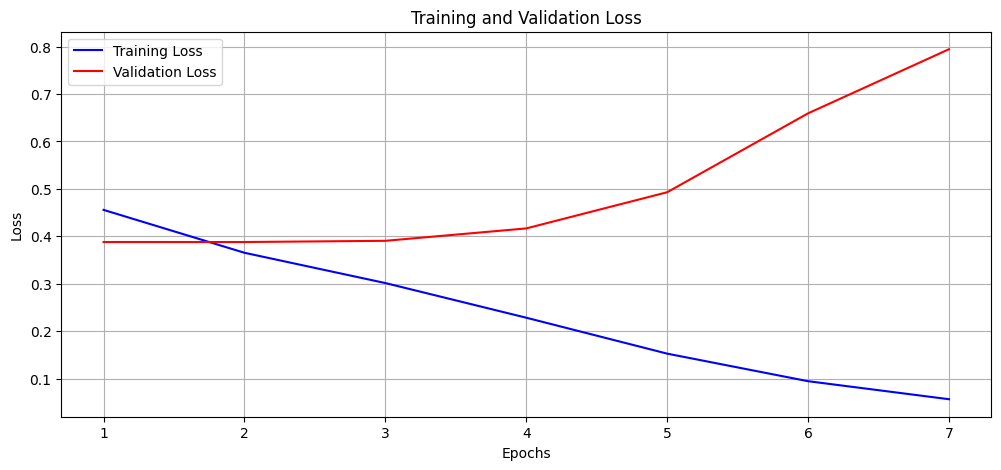

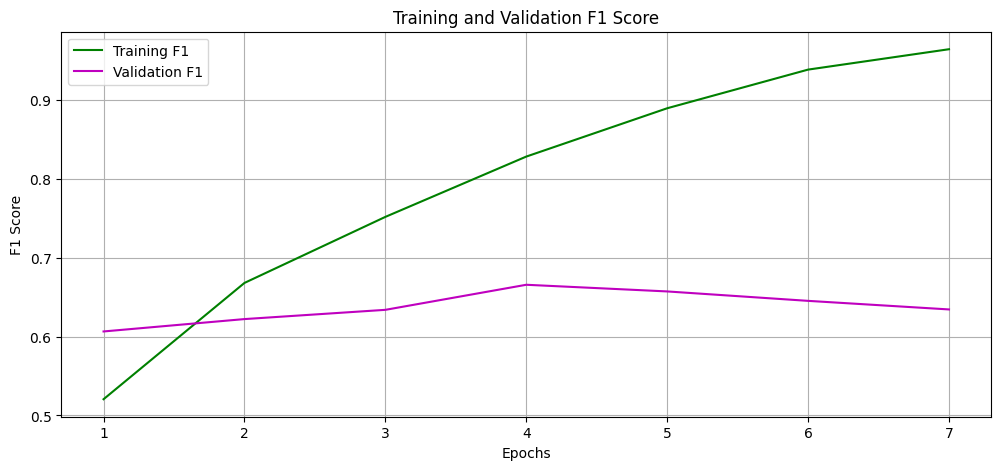

In [ ]:
trainer.plot_training_metrics()